In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
timm.list_models('mobilenet*',pretrained=True)

['mobilenet_edgetpu_v2_m.ra4_e3600_r224_in1k',
 'mobilenetv1_100.ra4_e3600_r224_in1k',
 'mobilenetv1_100h.ra4_e3600_r224_in1k',
 'mobilenetv1_125.ra4_e3600_r224_in1k',
 'mobilenetv2_050.lamb_in1k',
 'mobilenetv2_100.ra_in1k',
 'mobilenetv2_110d.ra_in1k',
 'mobilenetv2_120d.ra_in1k',
 'mobilenetv2_140.ra_in1k',
 'mobilenetv3_large_100.miil_in21k',
 'mobilenetv3_large_100.miil_in21k_ft_in1k',
 'mobilenetv3_large_100.ra4_e3600_r224_in1k',
 'mobilenetv3_large_100.ra_in1k',
 'mobilenetv3_large_150d.ra4_e3600_r256_in1k',
 'mobilenetv3_rw.rmsp_in1k',
 'mobilenetv3_small_050.lamb_in1k',
 'mobilenetv3_small_075.lamb_in1k',
 'mobilenetv3_small_100.lamb_in1k',
 'mobilenetv4_conv_aa_large.e230_r384_in12k',
 'mobilenetv4_conv_aa_large.e230_r384_in12k_ft_in1k',
 'mobilenetv4_conv_aa_large.e230_r448_in12k_ft_in1k',
 'mobilenetv4_conv_aa_large.e600_r384_in1k',
 'mobilenetv4_conv_blur_medium.e500_r224_in1k',
 'mobilenetv4_conv_large.e500_r256_in1k',
 'mobilenetv4_conv_large.e600_r384_in1k',
 'mobilenet

In [3]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def mediapipeimg(image):

  with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    results = hands.process(image)
    # print('Handedness:', results.multi_handedness)



    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    landmark_tangan=[]
    for hand_landmarks in results.multi_hand_landmarks:
     
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      fitur = []
      data = []
      for h in range(0,20):
          x = hand_world_landmarks.landmark[h].x
          y = hand_world_landmarks.landmark[h].y
          z = hand_world_landmarks.landmark[h].z
          fitur.append(x)
          fitur.append(y)
          fitur.append(z)
      data.extend(fitur)
      x = 0
      y = 0
      z = 0



    return results, annotated_image, data

In [4]:
import cv2
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import torchvision.transforms as T


base_options = python.BaseOptions(model_asset_path='../gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)



def handGesture(img):
    landmarks = []
    errr = None
    # image = mp.Image.create_from_file(img)
    imgPil = T.ToPILImage()(img)
        
    medPil = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(imgPil))
    recognition_result = recognizer.recognize(medPil)
    hand_landmarks = recognition_result.hand_landmarks
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr
    else:
        errr = 1
        return landmarks, errr



In [5]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets


class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.transform = transform
        self.featureExtraction = featureExtraction
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        if self.featureExtraction:
            feature, err = self.featureExtraction(image)
            if (err != None):
                return self.__getitem__(idx + 1)
            else:
                custom_features = feature
        
        
        hasil = {
            'image': image,
            'labels': label,
            'id_class': idx,
            'custom_features': custom_features,
            'data': data
        }
        
        return hasil

In [6]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
     transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../../dataset/hagrid/hagrid-min/", transform=train_transform, featureExtraction=handGesture)

print(type(dataset))

<class '__main__.dawtaset'>


In [7]:
# train_dataset, val_dataset, test_dataset = random_split(dataset, [1500, 750, 265])

train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=1, drop_last=True)
# val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)
# test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

# print("Length of the train_loader:", len(train_loader))
# print("Length of the val_loader:", len(val_loader))
# print("Length of the test_loader:", len(test_loader))

In [8]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_loader.dataset)]).melt(),
#             x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_loader.dataset)]).melt(), 
#             x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_loader.dataset)]).melt(),
#             x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Test Set')

In [9]:
import torch.nn.functional as F

class MyModelDefault(nn.Module):
    def __init__(self):
        super(MyModelDefault, self).__init__()
        self.cnn = timm.create_model('mobilenetv3_small_100', pretrained=True)
        self.cnn.classifier = nn.Linear(
            self.cnn.classifier.in_features, 300
        )
        self.fc1 = nn.Linear(self.cnn.classifier.out_features + 63, 100)
        self.fc2 = nn.Linear(100, 18)
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = data
        x = torch.cat((x1, x2), dim=1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyModelDefault()
model.to(device)

MyModelDefault(
  (cnn): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): ReLU(inplace=True)
            (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (gate): Hardsigmoid()
          )
          (conv_pw): Conv2d(

In [10]:
from torch import tensor
import torchvision.transforms as T
from PIL import Image as im 
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()gustig
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)


trainingEpoch_loss = []
validationEpoch_loss = []
validation_acc = []

for epoch in range(100):
    train_loss = 0.0
    for i, data in enumerate(train_loader.dataset, 0):
        
                      
        optimizer.zero_grad()
        outputs = model(torch.as_tensor(data["image"]).unsqueeze(0).to(device), 
                        torch.as_tensor(data["custom_features"]).unsqueeze(0).to(device))
        loss = criterion(outputs, torch.as_tensor(data["labels"]).unsqueeze(0).to(device))
        # print(torch.as_tensor(data["image"].unsqueeze(0)))
        # print(torch.as_tensor(data["custom_features"]).unsqueeze(0))
        # print(torch.as_tensor(data["labels"]).unsqueeze(0))
        loss.backward()
        optimizer.step()
                # writer.add_scalar("Loss/train", loss, epoch)
        train_loss += loss.item()
        
    valid_loss = 0.0
    # model.eval()     # Optional when not using Model Specific layer
    # with torch.no_grad():
    #     total_correct = 0
    #     total_samples = 0
    #     for i, data in enumerate(val_loader.dataset, 0): 
    #         # Forward Pass
    #         target = model(torch.as_tensor(data["image"]).unsqueeze(0), 
    #                     torch.as_tensor(data["custom_features"]).unsqueeze(0))
    #         # Find the Loss
    #         loss = criterion(target,torch.as_tensor(data["labels"]).unsqueeze(0))
        
    #         _, predicted = torch.max(target, 1)
    #         total_correct += (predicted == torch.as_tensor(data["labels"]).unsqueeze(0)).sum().item()
    #         total_samples += torch.as_tensor(data["labels"]).unsqueeze(0).size(0)
    #         # Calculate Loss
    #         valid_loss += loss.item()
    #     validation_accuracy = total_correct / total_samples
    #     # print(f"Epoch [{epoch+1}/{epoch}] Validation Accuracy: {validation_accuracy:.4f}")
 
    # print(f'Epoch {epoch+1} \t\t Validation Accuracy: {validation_accuracy:.4f} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    print(f'Epoch {epoch+1}  \t\t Training Loss: {train_loss / len(train_loader)} \t\t')
    trainingEpoch_loss.append(train_loss)
    validationEpoch_loss.append(valid_loss)
    # validation_acc.append(validation_accuracy)
    
                   
            
    

Epoch 1  		 Training Loss: 0.07032975444103635 		
Epoch 2  		 Training Loss: 0.06994354301190828 		
Epoch 3  		 Training Loss: 0.0683400903764654 		
Epoch 4  		 Training Loss: 0.07810195551983551 		
Epoch 5  		 Training Loss: 0.08966191953921199 		
Epoch 6  		 Training Loss: 0.09902662137214246 		
Epoch 7  		 Training Loss: 0.08995752164708971 		
Epoch 8  		 Training Loss: 0.09086995749193223 		
Epoch 9  		 Training Loss: 0.09121480336264967 		
Epoch 10  		 Training Loss: 0.08677378430055555 		
Epoch 11  		 Training Loss: 0.08509942845965988 		
Epoch 12  		 Training Loss: 0.08557988399466072 		
Epoch 13  		 Training Loss: 0.08465679195516816 		
Epoch 14  		 Training Loss: 0.08690270055451499 		
Epoch 15  		 Training Loss: 0.09356504902165655 		
Epoch 16  		 Training Loss: 0.09188071074064827 		
Epoch 17  		 Training Loss: 0.09310692847961055 		
Epoch 18  		 Training Loss: 0.08572884144860826 		
Epoch 19  		 Training Loss: 0.08888454938356177 		
Epoch 20  		 Training Loss: 0.08880682084

In [11]:
torch.save(model.state_dict(), "model_mobilenet+feature_hagrid")

<function matplotlib.pyplot.show(close=None, block=None)>

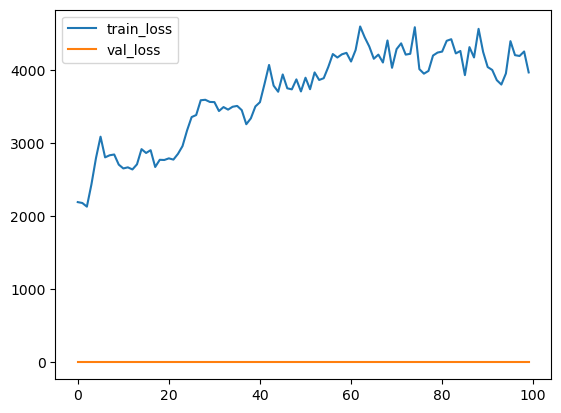

In [12]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

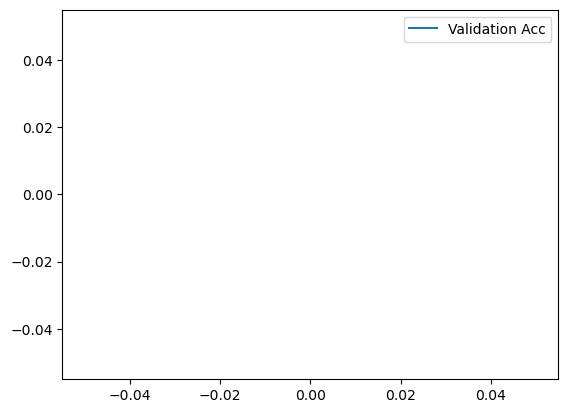

In [13]:
from matplotlib import pyplot as plt
plt.plot(validation_acc, label='Validation Acc')

plt.legend()
plt.show

In [14]:
torch.save(model, "ghosnet+feature.pth")

In [ ]:
modelll = torch.load("ghosnet+feature.pth")
modelll

C:\Users\intel\AppData\Local\Temp\ipykernel_34804\3034128694.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelll = torch.load("ghosnet+feature.pth")


MyModelDefault(
  (cnn): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): ReLU(inplace=True)
            (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (gate): Hardsigmoid()
          )
          (conv_pw): Conv2d(

: 